In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(csv_path, columns, title=None, figsize=(4,3.5), alt_labels=None):
    """
    Plot selected columns from a single-row CSV as a bar chart.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file (should have 1 row).
    columns : list of str
        Column names to plot, in order.
    title : str, optional
        Title for the plot.
    figsize : tuple, default (8,5)
        Figure size in inches.
    alt_labels : list of str, optional
        Alternative labels to display on the x-axis instead of raw column names.
        Must be the same length as `columns` if provided.
    """
    df = pd.read_csv(csv_path)
    if df.shape[0] == 0:
        raise ValueError("CSV is empty.")
    if df.shape[0] > 1:
        print(f"Warning: CSV has {df.shape[0]} rows; using the first row.")
    row = df.iloc[0]

    # Collect values in the requested order
    values = []
    for c in columns:
        if c not in row:
            raise KeyError(f"Column '{c}' not found in CSV.")
        try:
            values.append(float(row[c]))
        except Exception:
            values.append(float("nan"))

    # Use alternative labels if provided
    if alt_labels:
        if len(alt_labels) != len(columns):
            raise ValueError("alt_labels must have the same length as columns.")
        labels = alt_labels
    else:
        labels = columns

    fig, ax = plt.subplots(figsize=figsize)
    x = range(len(columns))
    bars = ax.bar(x, values)

    ax.set_xticks(list(x))
    ax.set_xticklabels(labels, rotation=0)
    ax.set_title(title, fontsize=18)
    ax.set_ylabel("metric value", fontsize=12)
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_ylabel("metric value")
    if title:
        ax.set_title(title)
    y_max = 1.0
    ax.set_ylim(0, y_max)

    # Annotate each bar with value (3 sig figs)
    for bar, v in zip(bars, values):
        if pd.notna(v):
            label = f"{v:.3g}"
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                label,
                ha="center", va="bottom",
                fontsize=10
            )

    plt.tight_layout()
    plt.show()


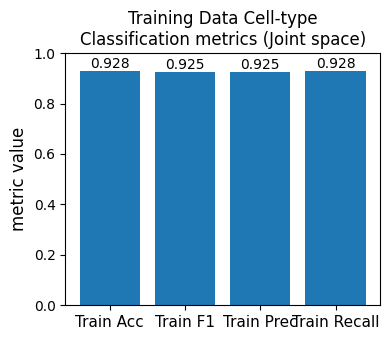

In [2]:
plot_metrics(
    csv_path="wandb_export_2025-09-10T07_46_31.673-04_00.csv",
    columns=[
        "real-train-joint/accuracy",
        "real-train-joint/f1_score",
        "real-train-joint/precision",
        "real-train-joint/recall",
    ],
    alt_labels=["Train Acc", "Train F1", "Train Prec", "Train Recall"],
    title="Training Data Cell-type\nClassification metrics (Joint space)"
)


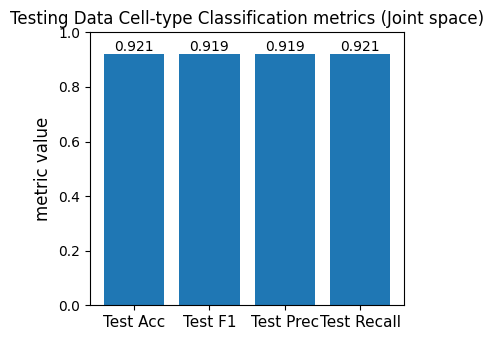

In [3]:
plot_metrics(
    csv_path="wandb_export_2025-09-10T07_46_31.673-04_00.csv",
    columns=[
        "real-test-joint/accuracy",
        "real-test-joint/f1_score",
        "real-test-joint/precision",
        "real-test-joint/recall",
    ],
    alt_labels=["Test Acc", "Test F1", "Test Prec", "Test Recall"],
    title="Testing Data Cell-type Classification metrics (Joint space)"
)


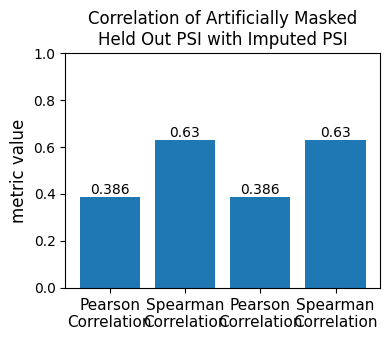

In [ ]:
plot_metrics(
    csv_path="wandb_export_2025-09-10T07_46_31.673-04_00.csv",
    columns=[
        "impute-test/psi_pearson_corr_masked_atse",
        "impute-test/psi_spearman_corr_masked_atse",
    ],
    alt_labels=["Pearson\nCorrelation", "Spearman\nCorrelation"],
    title="Correlation of Artificially Masked\nHeld Out PSI with Imputed PSI"
)


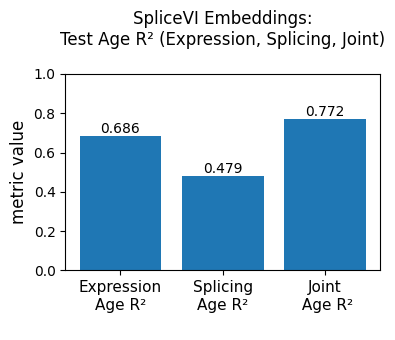

In [5]:
plot_metrics(
    csv_path="wandb_export_2025-09-10T07_46_31.673-04_00.csv",
    columns=[
        "real-test-expression/age_r2",
        "real-test-splicing/age_r2",
        "real-test-joint/age_r2",
    ],
    alt_labels=["Expression\nAge R²\n", "Splicing\nAge R²\n", "Joint\n Age R²\n"],
    title="SpliceVI Embeddings:\nTest Age R² (Expression, Splicing, Joint)\n"
)


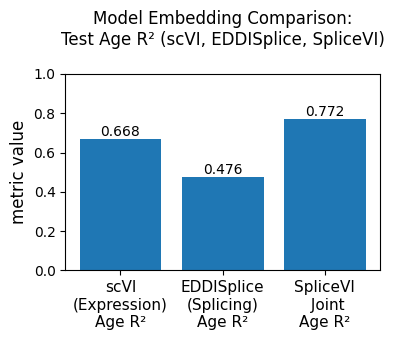

In [6]:
plot_metrics(
    csv_path="wandb_export_2025-09-10T07_46_31.673-04_00.csv",
    columns=[
        "age_r2_scvi", 
        "age_r2_eddisplice",
        "real-test-joint/age_r2",
    ],
    alt_labels=["scVI\n(Expression)\nAge R²", "EDDISplice\n(Splicing)\nAge R²",  "SpliceVI\n Joint\nAge R²"],
    title="Model Embedding Comparison:\nTest Age R² (scVI, EDDISplice, SpliceVI)\n"
)


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap

def plot_grouped_metrics(
    csv_path,
    columns,
    title=None,
    figsize=(5,3.7),
    alt_labels=None,          # one label per metric group (e.g., ["Train Acc","Train F1","Train Prec","Train Recall"])
    wrap_width=0,             # set to e.g. 12 to auto-wrap x tick labels
    value_size=11,
):
    """
    Plot grouped bars for metrics across embeddings (Expression, Splicing, Joint).

    Assumes `columns` are provided in groups of three per metric in the order:
    [expr_metric1, spl_metric1, joint_metric1, expr_metric2, spl_metric2, joint_metric2, ...].

    Parameters
    ----------
    csv_path : str
        Path to single-row CSV.
    columns : list[str]
        Column names in the order described above.
    title : str, optional
        Figure title.
    figsize : (float, float)
        Figure size in inches.
    alt_labels : list[str], optional
        X-tick labels for each metric group (length must equal num_groups).
    wrap_width : int
        If >0, wrap x tick labels to this many characters per line.
    value_size : int
        Font size for the value annotations above bars.
    """

    # Colors (Expression=pink, Splicing=light green, Joint=dark blue)
    COLORS = {
        "expression": "#EEA9C8",  # pink
        "splicing":   "#A7D8A0",  # light green
        "joint":      "#1F3A8A",  # dark blue
    }
    EMBED_ORDER = ["expression", "splicing", "joint"]  # order within each group

    # Basic checks
    if len(columns) % 3 != 0:
        raise ValueError("`columns` length must be a multiple of 3 (expr, spl, joint per metric).")

    df = pd.read_csv(csv_path)
    if df.shape[0] == 0:
        raise ValueError("CSV is empty.")
    if df.shape[0] > 1:
        print(f"Warning: CSV has {df.shape[0]} rows; using the first row.")
    row = df.iloc[0]

    # Number of metric groups
    num_groups = len(columns) // 3

    # Build values matrix of shape (num_groups, 3) in the defined EMBED_ORDER
    values = np.zeros((num_groups, 3)) * np.nan
    group_labels = []

    for g in range(num_groups):
        triplet = columns[3*g : 3*g + 3]
        # Map each col in the triplet to its embedding by substring
        mapped = {}
        for col in triplet:
            col_l = col.lower()
            if "expression" in col_l or "/ge" in col_l:
                mapped["expression"] = col
            elif "splicing" in col_l or "/spl" in col_l:
                mapped["splicing"]   = col
            elif "joint" in col_l:
                mapped["joint"]      = col
            else:
                # If none matched, fall back to position (0,1,2) -> expr,spl,joint
                # but still try to float-convert
                pass

        # Fill in values following EMBED_ORDER, fall back to positional if needed
        for j, emb in enumerate(EMBED_ORDER):
            col_name = mapped.get(emb, triplet[j])  # fallback: positional
            try:
                values[g, j] = float(row[col_name])
            except Exception:
                values[g, j] = np.nan

        # Collect group label
        if alt_labels is not None:
            if len(alt_labels) != num_groups:
                raise ValueError("`alt_labels` length must match number of metric groups.")
            group_labels = list(alt_labels)
        else:
            # If no alt labels, derive a simple label from first col in the triplet
            raw = triplet[0].split("/")[-1]  # e.g., "accuracy"
            group_labels.append(raw.replace("_", " ").title())

    # Optional wrapping of x tick labels
    if wrap_width and wrap_width > 0:
        group_labels = ['\n'.join(textwrap.wrap(lbl, width=wrap_width)) for lbl in group_labels]

    # Plot
    fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(num_groups)
    width = 0.15  # bar width
    offsets = [-0.27, 0.0, 0.27]  # expr, spl, joint around each group center
        # Increase y max (e.g., add 10% headroom above tallest bar)


    bars_per_emb = []
    for j, emb in enumerate(EMBED_ORDER):
        bars = ax.bar(x + offsets[j], values[:, j], width=width, label=emb.capitalize(), color=COLORS[emb])
        bars_per_emb.append(bars)

    # Axes & title
    ax.set_xticks(x)
    ax.set_xticklabels(group_labels)
    ax.set_ylabel("metric value")
    if title:
        ax.set_title(title)

    if title:
        ax.set_title(title, fontsize=11)  # or any size you like

    y_max = 1.0
    ax.set_ylim(0, y_max)


    # Annotate values (3 significant figures) above each bar
    for bars in bars_per_emb:
        for bar in bars:
            v = bar.get_height()
            if not np.isnan(v):
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    v,
                    f"{v:.3g}",
                    ha="center",
                    va="bottom",
                    fontsize=10
                )

    ax.legend(
    title="Embedding",
    ncols=3,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),   # push outside
    frameon=False
)
    fig.tight_layout()
    plt.show()


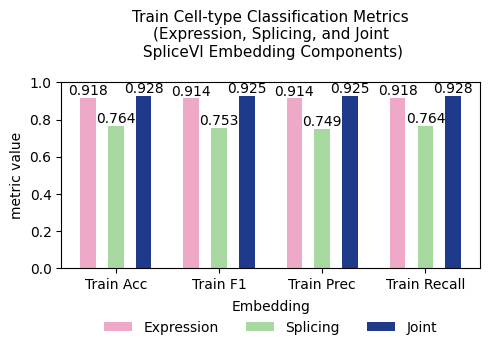

In [13]:
plot_grouped_metrics(
    csv_path="wandb_export_2025-09-10T07_46_31.673-04_00.csv",
    columns=[
        "real-train-expression/accuracy",
        "real-train-splicing/accuracy",
        "real-train-joint/accuracy",
        "real-train-expression/f1_score",
        "real-train-splicing/f1_score",
        "real-train-joint/f1_score",
        "real-train-expression/precision",
        "real-train-splicing/precision",
        "real-train-joint/precision",
        "real-train-expression/recall",
        "real-train-splicing/recall",
        "real-train-joint/recall",
    ],
    alt_labels=["Train Acc", "Train F1", "Train Prec", "Train Recall"],  # one per metric group
    title="Train Cell-type Classification Metrics\n(Expression, Splicing, and Joint\n SpliceVI Embedding Components)\n",
    wrap_width=12  # optional: wrap long x labels
)


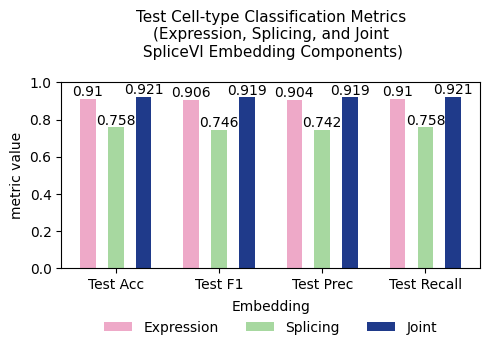

In [14]:
plot_grouped_metrics(
    csv_path="wandb_export_2025-09-10T07_46_31.673-04_00.csv",
    columns=[
        "real-test-expression/accuracy",
        "real-test-splicing/accuracy",
        "real-test-joint/accuracy",
        "real-test-expression/f1_score",
        "real-test-splicing/f1_score",
        "real-test-joint/f1_score",
        "real-test-expression/precision",
        "real-test-splicing/precision",
        "real-test-joint/precision",
        "real-test-expression/recall",
        "real-test-splicing/recall",
        "real-test-joint/recall",
    ],
    alt_labels=["Test Acc", "Test F1", "Test Prec", "Test Recall"],  # one per metric group
    title="Test Cell-type Classification Metrics\n(Expression, Splicing, and Joint\n SpliceVI Embedding Components)\n",
    wrap_width=12  # optional: wrap long x labels
)
